# Lecture 3

Day 1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
import numpy as np
import scipy.integrate as spi
import scipy.stats as stats
import emcee
import astroML

Frequentist

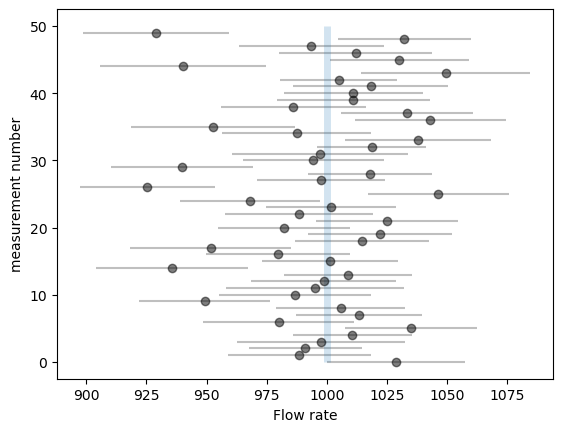

In [84]:
np.random.seed(2) # for reproducibility  
e = np.random.normal(30, 3, 50) 
F = np.random.normal(1000, e) # mean = 1000, std = error of device
 
%matplotlib inline 
import matplotlib.pyplot as plt 
 
fig, ax = plt.subplots() 
ax.errorbar(F, np.arange(50), xerr=e, fmt='ok', ecolor='gray', alpha=0.5) 
ax.vlines([1000], 0, 50, linewidth=5, alpha=0.2) 
ax.set_xlabel("Flow rate");ax.set_ylabel("measurement number"); 
plt.show()


In [85]:
w = 1. / e ** 2 
F_hat = np.sum(w * F) / np.sum(w) 
sigma_F = w.sum() ** -0.5 
print(F_hat,sigma_F)

998.6496963757094 4.113743971231106


Bayesian

In [86]:
def log_prior(theta): 
    return 1  # flat prior 
 
def log_likelihood(theta, F, e): 
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2) 
                         + (F - theta[0]) ** 2 / e ** 2) 
 
def log_posterior(theta, F, e): 
    return log_prior(theta) + log_likelihood(theta, F, e) 

In [87]:
# np.random.seed(2) # for reproducibility  
ndim = 1  # number of parameters in the model 
nwalkers = 50  # number of MCMC walkers 
nburn = 1000  # "burn-in" period to let chains stabilize 
nsteps = 2000  # number of MCMC steps to take 
 
# we'll start at random locations between 0 and 2000 
starting_guesses = 2000 * np.random.rand(nwalkers, ndim) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e]) 
sampler.run_mcmc(starting_guesses, nsteps) 
 
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim) 
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

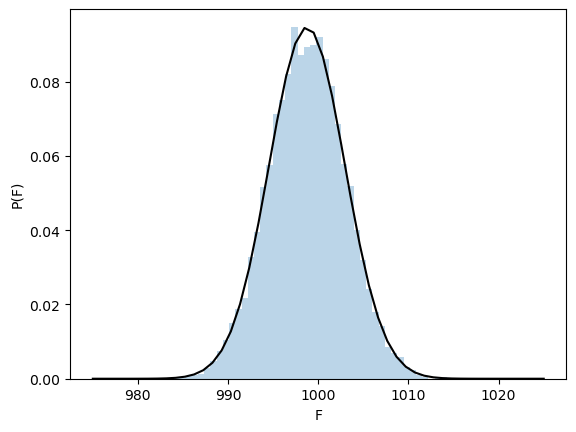

In [93]:
# plot a histogram of the sample 
from scipy import stats 
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, density=True) 
 
# plot a best-fit Gaussian 
F_fit = np.linspace(975, 1025) 
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit) 
 
plt.plot(F_fit, pdf, '-k') 
plt.xlabel("F"); plt.ylabel("P(F)")
plt.show()

In [89]:
print(sample)

[ 998.76583626  998.60206312  998.05661687 ... 1002.96548681 1002.96548681
 1004.30426812]


In [90]:
print(""" 
      F_true = {0} 
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements) 
      """.format(1000, np.mean(sample), np.std(sample), 50))

 
      F_true = 1000 
      F_est  = 999 +/- 4 (based on 50 measurements) 
      


Day 2

In [ ]:
np.random.seed(42)  # for reproducibility 
N = 100  # we'll use more samples for the more complicated model 
mu_true, sigma_true = 1000, 15  # stochastic flow rate model 
F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flow rate 
F = stats.poisson(F_true).rvs()  # observed flow rate: true flow rate plus Poisson errors. # additive noise
e = np.sqrt(F)  # root-N error, as above 

In [101]:
def log_likelihood(theta, F, e): 
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2)) 
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2)) 
 
# maximize likelihood <--> minimize negative likelihood 
def neg_log_likelihood(theta, F, e): 
    return -log_likelihood(theta, F, e) 
 
from scipy import optimize 
theta_guess = [900, 5] 
theta_est = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e)) 
print(""" 
      Maximum likelihood estimate for {0} data points: 
          mu={theta[0]:.0f}, sigma={theta[1]:.0f} 
      """.format(N, theta=theta_est))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114
 
      Maximum likelihood estimate for 100 data points: 
          mu=999, sigma=19 
      
